# Credit Card Default Prediction Project Documentation

The project involves data loading, preprocessing, feature engineering, model training, and evaluation using PySpark.

###Installing Pyspark


In [ ]:
!pip install pyspark

###Importing required Libraries and prerequisites


In [ ]:
from pyspark.sql import Row,SparkSession
from pyspark.sql.functions import mean,mode, abs, round, col, when, count, sum
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler,StandardScaler, MinMaxScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Data Loading and Initial Exploration

The project starts by loading two datasets: `Credit_card.csv` containing customer information and `Credit_card_label.csv` containing the target variable (default status). These datasets are joined based on the `Ind_ID` column.

###Creating a Spark Session and reading the **CSV** datasets

In [ ]:
spark = SparkSession.builder.appName("CreditCardAnalysis").getOrCreate()

df = spark.read.csv("/content/Credit_card.csv", header=True, inferSchema=True)
y = spark.read.csv("/content/Credit_card_label.csv", header=True, inferSchema=True)

# Join the dataframes on Ind_ID
df = df.join(y, on="Ind_ID", how="inner")

df.show(20)
print(df.count())

+-------+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+--------------+-------------+------------+----------+-----+--------+---------------+--------------+-----+
| Ind_ID|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|         Type_Income|           EDUCATION|      Marital_status|     Housing_type|Birthday_count|Employed_days|Mobile_phone|Work_Phone|Phone|EMAIL_ID|Type_Occupation|Family_Members|label|
+-------+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+--------------+-------------+------------+----------+-----+--------+---------------+--------------+-----+
|5008827|     M|        Y|            Y|       0|     180000.0|           Pensioner|    Higher education|             Married|House / apartment|        -18772|       365243|           1|         0|    0|       0|           NULL|             2|    1|


In [ ]:
count_label_0 = df.filter(df.label == 0).count()
count_label_1 = df.filter(df.label == 1).count()
print(f"Number of entries with label 0: {count_label_0}")
print(f"Number of entries with label 1: {count_label_1}")

Number of entries with label 0: 1373
Number of entries with label 1: 175


## Data Preprocessing

This section focuses on handling missing values and irrelevant columns. Columns like `Ind_ID`, `Mobile_phone`, `Work_Phone`, `Phone`, and `EMAIL_ID` are dropped as they are not considered relevant for the prediction task. Missing values in `Type_Occupation` are filled with "Unknown", and missing values in `Annual_income` and `Gender` are imputed with the mean and mode respectively. New features like `Age` and `Employment_Status` are derived from existing columns.

In [ ]:


null_counts = df.select([sum(col(c).isNull().cast("integer")).alias(c) for c in df.columns])
null_counts.show()

+------+------+---------+-------------+--------+-------------+-----------+---------+--------------+------------+--------------+-------------+------------+----------+-----+--------+---------------+--------------+-----+
|Ind_ID|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|Type_Income|EDUCATION|Marital_status|Housing_type|Birthday_count|Employed_days|Mobile_phone|Work_Phone|Phone|EMAIL_ID|Type_Occupation|Family_Members|label|
+------+------+---------+-------------+--------+-------------+-----------+---------+--------------+------------+--------------+-------------+------------+----------+-----+--------+---------------+--------------+-----+
|     0|     7|        0|            0|       0|           23|          0|        0|             0|           0|            22|            0|           0|         0|    0|       0|            488|             0|    0|
+------+------+---------+-------------+--------+-------------+-----------+---------+--------------+------------+--------------+-

In [ ]:
df = df.drop("Ind_ID","Mobile_phone","Work_Phone","Phone","EMAIL_ID")
df = df.fillna({"Type_Occupation" : "Unknown"})

In [ ]:
from pyspark.sql.functions import col, sum

null_counts = df.select([sum(col(c).isNull().cast("integer")).alias(c) for c in df.columns])
null_counts.show()

+------+---------+-------------+--------+-------------+-----------+---------+--------------+------------+--------------+-------------+---------------+--------------+-----+
|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|Type_Income|EDUCATION|Marital_status|Housing_type|Birthday_count|Employed_days|Type_Occupation|Family_Members|label|
+------+---------+-------------+--------+-------------+-----------+---------+--------------+------------+--------------+-------------+---------------+--------------+-----+
|     7|        0|            0|       0|           23|          0|        0|             0|           0|            22|            0|              0|             0|    0|
+------+---------+-------------+--------+-------------+-----------+---------+--------------+------------+--------------+-------------+---------------+--------------+-----+



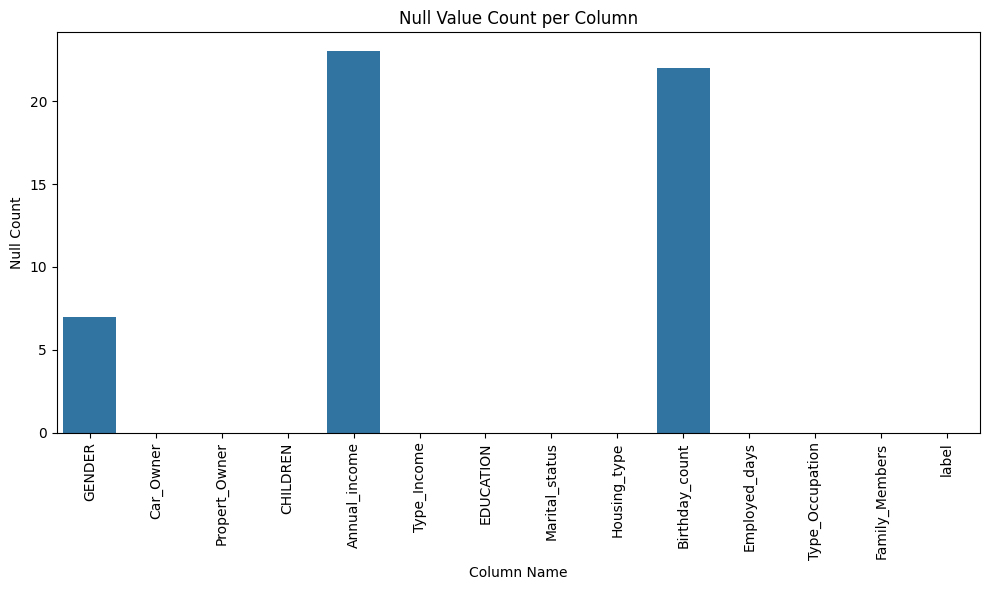

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
null_counts_pd = null_counts.toPandas()

# Transpose the DataFrame for plotting
null_counts_pd_transposed = null_counts_pd.melt(var_name='Column_Name', value_name='Null_Count')

plt.figure(figsize=(10, 6))
sns.barplot(x='Column_Name', y='Null_Count', data=null_counts_pd_transposed)
plt.xticks(rotation=90)
plt.title('Null Value Count per Column')
plt.xlabel('Column Name')
plt.ylabel('Null Count')
plt.tight_layout()
plt.show()

In [ ]:


mean_income = df.select(mean("Annual_income")).collect()[0][0]
df = df.fillna({"Annual_income":mean_income})

# Round off Annual_income to 1 decimal place
df = df.withColumn("Annual_income", round(col("Annual_income"), 1))

mode_gender = df.select("Gender").agg(mode("Gender")).collect()[0][0]
df = df.fillna({"Gender":mode_gender})

df = df.withColumn("Age", round(abs(col("Birthday_count") / 365)).cast("integer"))

df = df.withColumn("Employment_Status", when(col("Employed_days") > 0, None).otherwise(abs(col("Employed_days"))))

df = df.dropna(subset=['Age'])
df = df.dropna(subset=['Employment_Status'])
df = df.drop("Employed_days","Birthday_count")
df.show()
print(df.count())

+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+---------------+--------------+-----+---+-----------------+
|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|         Type_Income|           EDUCATION|      Marital_status|     Housing_type|Type_Occupation|Family_Members|label|Age|Employment_Status|
+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+---------------+--------------+-----+---+-----------------+
|     F|        Y|            N|       0|     315000.0|Commercial associate|    Higher education|             Married|House / apartment|        Unknown|             2|    1| 37|              586|
|     F|        Y|            N|       0|     191399.3|Commercial associate|    Higher education|             Married|House / apartment|        Unknown|             2|    1| 37|              586|
|     F|        Y|  

In [ ]:


null_counts = df.select([sum(col(c).isNull().cast("integer")).alias(c) for c in df.columns])
null_counts.show()

+------+---------+-------------+--------+-------------+-----------+---------+--------------+------------+---------------+--------------+-----+---+-----------------+
|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|Type_Income|EDUCATION|Marital_status|Housing_type|Type_Occupation|Family_Members|label|Age|Employment_Status|
+------+---------+-------------+--------+-------------+-----------+---------+--------------+------------+---------------+--------------+-----+---+-----------------+
|     0|        0|            0|       0|            0|          0|        0|             0|           0|              0|             0|    0|  0|                0|
+------+---------+-------------+--------+-------------+-----------+---------+--------------+------------+---------------+--------------+-----+---+-----------------+



In [ ]:


unique_counts_data = []
columns_to_exclude = ["Annual_income", "Birthday_count", "Employment_Status"]
for col_name in df.columns:
  if col_name not in columns_to_exclude:
      unique_count = df.select(col_name).distinct().count()
      unique_counts_data.append(Row(Column_Name=col_name, Unique_Count=unique_count))

unique_counts_df = spark.createDataFrame(unique_counts_data)
unique_counts_df.show()

+---------------+------------+
|    Column_Name|Unique_Count|
+---------------+------------+
|         GENDER|           2|
|      Car_Owner|           2|
|  Propert_Owner|           2|
|       CHILDREN|           6|
|    Type_Income|           4|
|      EDUCATION|           5|
| Marital_status|           5|
|   Housing_type|           6|
|Type_Occupation|          19|
| Family_Members|           7|
|          label|           2|
|            Age|          45|
+---------------+------------+



In [ ]:
unique_values_data = []
columns_to_exclude = ["Annual_income", "Birthday_count", "Employment_Status"]

for col_name in df.columns:
    if col_name not in columns_to_exclude:
        unique_values = [row[0] for row in df.select(col_name).distinct().collect()]
        unique_values_data.append(Row(Column_Name=col_name, Unique_Values=unique_values))

unique_values_df = spark.createDataFrame(unique_values_data)
unique_values_df.show(truncate=False)

+---------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Column_Name    |Unique_Values                                                                                                                                                                                                                                                                      |
+---------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|GENDER         |[F, M]                                                                                               

### Visualization: Column vs Unique Count

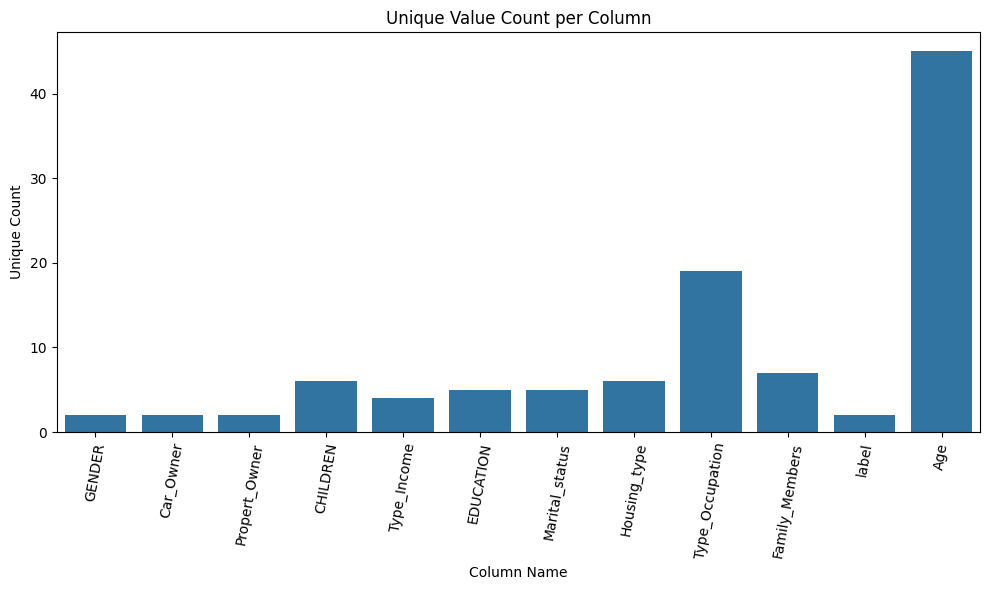

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
unique_counts_pd = unique_counts_df.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='Column_Name', y='Unique_Count', data=unique_counts_pd)
plt.xticks(rotation=80)
plt.title('Unique Value Count per Column')
plt.xlabel('Column Name')
plt.ylabel('Unique Count')
plt.tight_layout()
plt.show()

In [ ]:
df.show(20)


+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+---------------+--------------+-----+---+-----------------+
|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|         Type_Income|           EDUCATION|      Marital_status|     Housing_type|Type_Occupation|Family_Members|label|Age|Employment_Status|
+------+---------+-------------+--------+-------------+--------------------+--------------------+--------------------+-----------------+---------------+--------------+-----+---+-----------------+
|     F|        Y|            N|       0|     315000.0|Commercial associate|    Higher education|             Married|House / apartment|        Unknown|             2|    1| 37|              586|
|     F|        Y|            N|       0|     191399.3|Commercial associate|    Higher education|             Married|House / apartment|        Unknown|             2|    1| 37|              586|
|     F|        Y|  

In [ ]:
print(df.count())

1269


## Feature Engineering

Categorical features are converted into numerical representations using String Indexing and One-Hot Encoding. Numerical features are scaled using StandardScaler to ensure they have zero mean and unit variance, which is important for many machine learning algorithms. All features are then assembled into a single vector column.

In [ ]:
# Handle 'GENDER'
indexer_gender = StringIndexer(inputCol="GENDER", outputCol="GENDER_indexed", handleInvalid="keep")
df = indexer_gender.fit(df).transform(df)

# Handle 'Car_Owner'
indexer_car = StringIndexer(inputCol="Car_Owner", outputCol="Car_Owner_indexed", handleInvalid="keep")
df = indexer_car.fit(df).transform(df)

# Handle 'Type_Income'
indexer_income = StringIndexer(inputCol="Type_Income", outputCol="Type_Income_indexed", handleInvalid="keep")
df = indexer_income.fit(df).transform(df)

# Handle other categorical features (Propert_Owner, EDUCATION, Marital_status, Housing_type, Type_Occupation)
categorical_cols_remaining = ['Propert_Owner', 'EDUCATION', 'Marital_status', 'Housing_type', 'Type_Occupation']

for col_name in categorical_cols_remaining:
    indexer = StringIndexer(inputCol=col_name, outputCol=col_name + "_indexed", handleInvalid="keep")
    df = indexer.fit(df).transform(df)
    # Note: One-Hot Encoding will be done after assembling all indexed categorical features

df.show(5)

+------+---------+-------------+--------+-------------+--------------------+----------------+--------------+-----------------+---------------+--------------+-----+---+-----------------+--------------+-----------------+-------------------+---------------------+-----------------+----------------------+--------------------+-----------------------+
|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|         Type_Income|       EDUCATION|Marital_status|     Housing_type|Type_Occupation|Family_Members|label|Age|Employment_Status|GENDER_indexed|Car_Owner_indexed|Type_Income_indexed|Propert_Owner_indexed|EDUCATION_indexed|Marital_status_indexed|Housing_type_indexed|Type_Occupation_indexed|
+------+---------+-------------+--------+-------------+--------------------+----------------+--------------+-----------------+---------------+--------------+-----+---+-----------------+--------------+-----------------+-------------------+---------------------+-----------------+----------------------+-----

### Scale Numerical Features

In [ ]:
# Identify numerical columns
numerical_cols = ['Annual_income', 'Age', 'Employment_Status', 'Family_Members']

# Assemble numerical features into a single vector column
assembler_numerical = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features_assembled")
df = assembler_numerical.transform(df)

# Scale the numerical features
scaler = StandardScaler(inputCol="numerical_features_assembled", outputCol="scaled_numerical_features", withStd=True, withMean=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

df.show(5)

+------+---------+-------------+--------+-------------+--------------------+----------------+--------------+-----------------+---------------+--------------+-----+---+-----------------+--------------+-----------------+-------------------+---------------------+-----------------+----------------------+--------------------+-----------------------+----------------------------+-------------------------+
|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|         Type_Income|       EDUCATION|Marital_status|     Housing_type|Type_Occupation|Family_Members|label|Age|Employment_Status|GENDER_indexed|Car_Owner_indexed|Type_Income_indexed|Propert_Owner_indexed|EDUCATION_indexed|Marital_status_indexed|Housing_type_indexed|Type_Occupation_indexed|numerical_features_assembled|scaled_numerical_features|
+------+---------+-------------+--------+-------------+--------------------+----------------+--------------+-----------------+---------------+--------------+-----+---+-----------------+-----------

### Assemble Features

In [ ]:
# Identify the indexed categorical feature columns and scaled numerical feature column
indexed_categorical_cols = [col for col in df.columns if col.endswith("_indexed")]
scaled_numerical_col = "scaled_numerical_features"

# Apply One-Hot Encoding to all indexed categorical features
encoders = [OneHotEncoder(inputCol=col, outputCol=col.replace("_indexed", "_encoded")) for col in indexed_categorical_cols]

from pyspark.ml import Pipeline
pipeline_encoder = Pipeline(stages=encoders)
df = pipeline_encoder.fit(df).transform(df)

# Identify the encoded categorical feature columns
encoded_categorical_cols = [col for col in df.columns if col.endswith("_encoded")]


# Combine all feature columns (scaled numerical and encoded categorical) into a single vector column
feature_columns = [scaled_numerical_col] + encoded_categorical_cols
assembler_final = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler_final.transform(df)

df.select("features", "label").show(5, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                             |label|
+-----------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|(49,[0,1,2,3,4,7,9,13,15,19,24,31],[0.9947301403796339,-0.3817835611988816,-0.867763200416552,-0.2692010718092772,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])  |1    |
|(49,[0,1,2,3,4,7,9,13,15,19,24,31],[-0.06843280492023593,-0.3817835611988816,-0.867763200416552,-0.2692010718092772,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|1    |
|(49,[0,1,2,3,4,7,9,13,15,19,24,31],[0.9947301403796339,-0.3817835611988816,-0.867763200416552,-0.2692010718092772,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])  |1    |
|(49,[0,1,2,3,4,7,11,13,15,19,24,31],[0.994730140379

### Split Data into Training and Testing Sets

In [ ]:
# Split the data into training and testing sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

print("Training Data Count:", train_data.count())
print("Testing Data Count:", test_data.count())

train_data.show(5, truncate=False)
test_data.show(5, truncate=False)

Training Data Count: 1048
Testing Data Count: 221
+------+---------+-------------+--------+-------------+--------------------+-----------------------------+--------------+-----------------+---------------+--------------+-----+---+-----------------+--------------+-----------------+-------------------+---------------------+-----------------+----------------------+--------------------+-----------------------+----------------------------+----------------------------------------------------------------------------------+--------------+-----------------+-------------------+---------------------+-----------------+----------------------+--------------------+-----------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+
|GENDER|Car_Owner|Propert_Owner|CHILDREN|Annual_income|Type_Income         |EDUCATION                    |Marital_status|Housing_type     |Type_Occupation|Family_Memb

## Model Training and Evaluation

A Logistic Regression model is trained on the preprocessed and engineered features. The data is split into training and testing sets to evaluate the model's performance. The Area Under the ROC Curve (AUC) and Accuracy are used as evaluation metrics to assess the model's ability to predict credit card defaults.

In [ ]:
# Initialize Logistic Regression model
lr = LogisticRegression(labelCol="label", featuresCol="features")

# Train the model on the training data
lr_model = lr.fit(train_data)

print("Logistic Regression model training complete.")

Logistic Regression model training complete.


### Train Logistic Regression Model

In [ ]:
# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Select (prediction, true label) and call the accuracy evaluator
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Evaluate the model
auc = evaluator.evaluate(predictions)
print(f"Area under ROC curve: {auc}")

# We can also calculate other metrics manually if needed, e.g., Accuracy, Precision, Recall, F1-score
# For example, to calculate accuracy:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(predictions.count())
print(f"Accuracy: {accuracy}")

# To get a confusion matrix (requires converting to Pandas for easier display)
# from pyspark.sql.functions import col
# confusion_matrix = predictions.groupBy("label", "prediction").count().orderBy("label", "prediction").toPandas()
# print("Confusion Matrix:")
# print(confusion_matrix)

Area under ROC curve: 0.6661176987263937
Accuracy: 0.8823529411764706


## Conclusion

Based on the evaluation metrics, the performance of the Logistic Regression model is assessed. Further steps could involve exploring other machine learning algorithms, hyperparameter tuning, or more advanced feature engineering techniques to potentially improve the model's predictive power.